# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('../Resources/LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Assessment of data types

In [6]:
# lets evaluate which columns have non-numeric values so we can encode those as part of pre-processing
# as it is difficult to view 86 columns in 1 go, we will use exclude parameter in describe method 
#to select only those which are non-numeric that need to be addressed, including the dates and format of date columns
df.describe(exclude=[np.number])

,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,initial_list_status,next_pymnt_d,application_type,hardship_flag,debt_settlement_flag
count,68817,68817,68817,68817,68817,68817,68817,68817,68817,68817
unique,4,3,3,2,1,2,2,2,1,1
top,MORTGAGE,Not Verified,Jan-2019,low_risk,n,w,May-2019,Individual,N,N
freq,36219,32895,31041,68470,68817,60292,42449,59206,68817,68817


In [7]:
#We got 10 columns that are not numeric (either ints or floats) out of which we have two date columns. 
#let's see if they are of datetime data type
print(df.issue_d.dtype, df.next_pymnt_d.dtype )

object object


In [8]:
#the date columns issue_D and next_pymnt_d are of String data types. We will have to convert them to date or use the string 
#function to conver the month names to month numbers or we can use the get_dummies to encode the month into columns

# Encoding

### In this notebook, we will apply only the integer encoding using labelencoder and compare the results with the results from credit_risk_resampling.ipynb notebook.   

In [9]:
# We will first do integer encoding of the above non-nuemeric columns (except for the loan_Status which is our target)

# Create the LabelEncoder instance
label_encoder = LabelEncoder()

# Home_ownership column
label_encoder.fit(df["home_ownership"])
df["home_ownership"] = label_encoder.transform(df["home_ownership"])

# Encoding Verification_Status column
label_encoder.fit(df["verification_status"])
df["verification_status"] = label_encoder.transform(df["verification_status"])

# Encoding payment_plan column
label_encoder.fit(df["pymnt_plan"])
df["pymnt_plan"] = label_encoder.transform(df["pymnt_plan"])

#Encoding initial_list_status column that has f or w values:  whole [1] vs. fractional[0]
label_encoder.fit(df["initial_list_status"])
df["initial_list_status"] = label_encoder.transform(df["initial_list_status"])

# Encoding application_type column that has 'individual' or 'joint applicant' as values
label_encoder.fit(df["application_type"])
df["application_type"] = label_encoder.transform(df["application_type"])

# Encoding hardship_flag column
label_encoder.fit(df["hardship_flag"])
df["hardship_flag"] = label_encoder.transform(df["hardship_flag"])

# Encoding debt_settlement_flag column
label_encoder.fit(df["debt_settlement_flag"])
df["debt_settlement_flag"] = label_encoder.transform(df["debt_settlement_flag"])

#Though it is not required, we will convert the below two columns to int data type converting 1.0 to 1 - binaary.
df["pub_rec_bankruptcies"] = df["pub_rec_bankruptcies"].astype('int')
df["tax_liens"] = df["tax_liens"].astype('int')

### Encoding Data using `get_dummies()`

In [10]:
# # Perform a binary encoding on the 'home_ownership', 'issue_d', 'verification_status', 'initial_list_status',  'next_pymnt_d' and 'application_type' columns
# df_encoded = pd.get_dummies(df, columns=['home_ownership', 'issue_d', 'verification_status', 'initial_list_status',  'next_pymnt_d', 'application_type'])
# df_encoded.head()

In [11]:
#Let's now address the date columns
# we will use Pandas Datetimeindex to extract the month numbers instead of using encoding function. This is much simpler.
# Encode month name
df['issue_month_num'] = pd.DatetimeIndex(df['issue_d']).month
df=df.drop('issue_d', axis=1) 

df['next_pymnt_month_num'] = pd.DatetimeIndex(df['next_pymnt_d']).month
df=df.drop('next_pymnt_d', axis=1) 

df['issue_month_num'].unique()

array([3, 2, 1], dtype=int64)

In [12]:
# let's check if we have the final data set in the right format. given that the date columns also converted to numeric,
# we will have all columns in number format either ints or floats. when we use exclude parameter we should get only one 
# column (loan_status wich is our target class.
df.describe(exclude=[np.number])

,loan_status
count,68817
unique,2
top,low_risk
freq,68470


In [13]:
# Saving the cleaned and encoded data set into a file for using in Risk ensamble  learning (credit_risk_ensemble.ipynb)
# file_path = Path('../Resources/credit_risk_encoded.csv')
# df.to_csv(file_path)

# Split the Data into Training and Testing

In [14]:
# Create our features
X = df.drop('loan_status', axis=1)

# Create our target
y = df['loan_status']

In [15]:
X.describe()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,issue_month_num,next_pymnt_month_num
count,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04,68817.0,68817.0,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,1.812779,8.821371e+04,0.669994,0.0,21.778153,0.217766,0.497697,...,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04,0.0,0.0,1.726172,4.616839
std,10277.348590,0.048130,288.062432,0.941313,1.155800e+05,0.719105,0.0,20.199244,0.718367,0.758122,...,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04,0.0,0.0,0.743862,0.486161
min,1000.000000,0.060000,30.890000,0.000000,4.000000e+01,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02,0.0,0.0,1.000000,4.000000
25%,9000.000000,0.088100,265.730000,1.000000,5.000000e+04,0.000000,0.0,13.890000,0.000000,0.000000,...,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04,0.0,0.0,1.000000,4.000000
50%,15000.000000,0.118000,404.560000,1.000000,7.300000e+04,1.000000,0.0,19.760000,0.000000,0.000000,...,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04,0.0,0.0,2.000000,5.000000
75%,24000.000000,0.155700,648.100000,3.000000,1.040000e+05,1.000000,0.0,26.660000,0.000000,1.000000,...,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04,0.0,0.0,2.000000,5.000000
max,40000.000000,0.308400,1676.230000,3.000000,8.797500e+06,2.000000,0.0,999.000000,18.000000,5.000000,...,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06,0.0,0.0,3.000000,5.000000


In [16]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [17]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, We only scale the features data (`X_train` and `X_testing`).

In [18]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [19]:
# Fit the Standard Scaler with the training data
std_scaler = scaler.fit(X_train)

In [20]:
# Scale the training and testing data
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

# Oversampling

In this section, We will compare two oversampling algorithms to determine which algorithm results in the best performance. We will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [21]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [22]:
# Train the Logistic Regression model using the resampled data
lr_model_ros = LogisticRegression(solver='lbfgs', random_state=1)
lr_model_ros.fit(X_resampled, y_resampled)
y_pred_ros = lr_model_ros.predict(X_test_scaled)

In [23]:
# Calculated the balanced accuracy score
blncd_acc_score_ros = balanced_accuracy_score(y_test, y_pred_ros)
blncd_acc_score_ros

0.8381112286860117

In [24]:
# Display the confusion matrix
ros_cmatrix=confusion_matrix(y_test, y_pred_ros)
pd.DataFrame(ros_cmatrix, columns=['Predicted_low', 'predicted_high'], index=['Actual_low', 'Actual_high'])

,Predicted_low,predicted_high
Actual_low,84,17
Actual_high,2659,14445


In [25]:
# Print the imbalanced classification report
imb_clf_report_ros = classification_report_imbalanced(y_test, y_pred_ros)
print(imb_clf_report_ros)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.83      0.84      0.06      0.84      0.70       101
   low_risk       1.00      0.84      0.83      0.92      0.84      0.70     17104

avg / total       0.99      0.84      0.83      0.91      0.84      0.70     17205



### SMOTE Oversampling

In [26]:
# Resample the training data with SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [27]:
# Train the Logistic Regression model using the resampled data
lr_model_smt = LogisticRegression(solver='lbfgs', random_state=1)
lr_model_smt.fit(X_resampled, y_resampled)
y_pred_smt = lr_model_smt.predict(X_test_scaled)

In [28]:
# Calculated the balanced accuracy score
blncd_acc_score_smt = balanced_accuracy_score(y_test, y_pred_smt)
blncd_acc_score_smt

0.832701979271828

In [29]:
# Display the confusion matrix
smt_cmatrix = confusion_matrix(y_test, y_pred_smt)
pd.DataFrame(smt_cmatrix, columns=['Predicted_low', 'predicted_high'], index=['Actual_low', 'Actual_high'])

,Predicted_low,predicted_high
Actual_low,81,20
Actual_high,2336,14768


In [30]:
# Print the imbalanced classification report
imb_clf_report_smt = classification_report_imbalanced(y_test, y_pred_smt)
print(imb_clf_report_smt)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.80      0.86      0.06      0.83      0.69       101
   low_risk       1.00      0.86      0.80      0.93      0.83      0.70     17104

avg / total       0.99      0.86      0.80      0.92      0.83      0.70     17205



# Undersampling

In this section, We will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. We will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [31]:
# Resample the data using the ClusterCentroids resampler
X_resampled, y_resampled = ClusterCentroids(random_state=1, sampling_strategy=1.0).fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'high_risk': 246, 'low_risk': 246})

In [32]:
# Train the Logistic Regression model using the resampled data
lr_model_cc = LogisticRegression(solver='lbfgs', random_state=1)
lr_model_cc.fit(X_resampled, y_resampled)
y_pred_cc = lr_model_cc.predict(X_test_scaled)

In [33]:
# Calculated the balanced accuracy score
blncd_acc_score_cc = balanced_accuracy_score(y_test, y_pred_cc)
blncd_acc_score_cc

0.8036074011984922

In [34]:
# Display the confusion matrix
cc_cmatrix = confusion_matrix(y_test, y_pred_cc)
pd.DataFrame(cc_cmatrix, columns=['Predicted_low', 'predicted_high'], index=['Actual_low', 'Actual_high'])

,Predicted_low,predicted_high
Actual_low,86,15
Actual_high,4178,12926


In [35]:
# Print the imbalanced classification report
imb_clf_report_cc = classification_report_imbalanced(y_test, y_pred_cc)
print(imb_clf_report_cc)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.85      0.76      0.04      0.80      0.65       101
   low_risk       1.00      0.76      0.85      0.86      0.80      0.64     17104

avg / total       0.99      0.76      0.85      0.86      0.80      0.64     17205



# Combination (Over and Under) Sampling

In this section, We will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. We will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [36]:
# Resample the training data with SMOTEENN
X_resampled, y_resampled = SMOTEENN(random_state=1).fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'high_risk': 51366, 'low_risk': 46881})

In [38]:
# Train the Logistic Regression model using the resampled data
lr_model_smtenn = LogisticRegression(solver='lbfgs', random_state=1)
lr_model_smtenn.fit(X_resampled, y_resampled)
y_pred_smtenn = lr_model_smtenn.predict(X_test_scaled)

In [39]:
# Calculated the balanced accuracy score
blncd_acc_score_smtenn = balanced_accuracy_score(y_test, y_pred_smtenn)
blncd_acc_score_smtenn

0.8369902472005853

In [40]:
# Display the confusion matrix
smenn_cmatrix = confusion_matrix(y_test, y_pred_smtenn)
pd.DataFrame(smenn_cmatrix, columns=['Predicted_low', 'predicted_high'], index=['Actual_low', 'Actual_high'])

,Predicted_low,predicted_high
Actual_low,83,18
Actual_high,2528,14576


In [41]:
# Print the imbalanced classification report
imb_clf_report_smtenn = classification_report_imbalanced(y_test, y_pred_smtenn)
print(imb_clf_report_smtenn)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.85      0.06      0.84      0.70       101
   low_risk       1.00      0.85      0.82      0.92      0.84      0.70     17104

avg / total       0.99      0.85      0.82      0.91      0.84      0.70     17205



# Evaluation

From the oversample/undersample techniques used above, let's answer the following quesitons:
* Which model had the best balanced accuracy score?
* Which model had the best recall score?
* Which model had the best geometric mean score?
* Did the encoding technique used in this notebook had any impact on the results compared to previous notebook?

### Wouldnt it be nice to graphically compare the models taking a snapshot of all the metrics? Let's plot then! 
We will define a function that plots a comparison of the metrics

In [42]:
def cmatrix_plot(matrix, bac_score):
    """function to plot classification metrics and balanced accuracy score"""
    
    cmatrix_df = pd.DataFrame(columns=['model', 'TN', 'FP', 'FN', 'TP'])
    for k, v in matrix.items():
        v= v.ravel()
        cmatrix_df = cmatrix_df.append({'model': k, 'TN': int(v[0]), 'FP': int(v[1]), 'FN': int(v[2]), 'TP': int(v[3])}, ignore_index=True)

    cmatrix_df.set_index('model', inplace=True)
    cmatrix_df['bac'] =  [round(x,2) for x in bac_score]
    cmatrix_df['pre'] =  cmatrix_df.apply(lambda row: round(row.TP/(row.FP+row.TP), 2), axis=1)
    cmatrix_df['rec'] =  cmatrix_df.apply(lambda row: round(row.TP/(row.FN+row.TP), 2), axis=1)
    cmatrix_df['spe'] =  cmatrix_df.apply(lambda row: round(row.TN/(row.TN+row.FP), 2), axis=1)
    cmatrix_df['geo'] =  cmatrix_df.apply(lambda row: round((row.rec + row.spe)/2, 2), axis=1)
    cmatrix_df = cmatrix_df.drop(['TN', 'FN', 'FP', 'TP'], axis=1)
    metrics_plot= cmatrix_df.plot(kind='bar', use_index=False, grid=True, figsize=(10, 5), label=False, 
                  position=1, table=True, rot=15, title='Classification Metrics using Integer Encoding')
    
    return metrics_plot


Bad key "text.kerning_factor" on line 4 in
C:\Users\TinkerBell\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


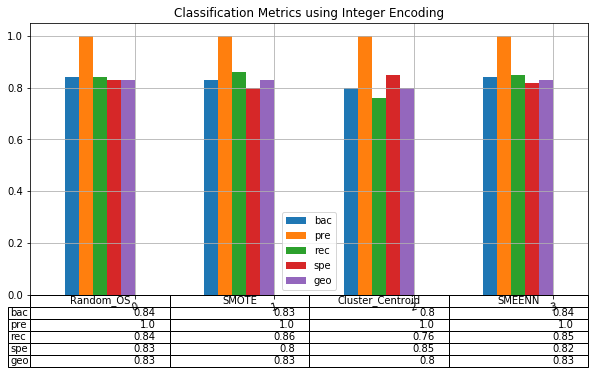

In [43]:
cmatrix={'Random_OS': ros_cmatrix, 'SMOTE': smt_cmatrix, 'Cluster_Centroid': cc_cmatrix, 'SMEENN': smenn_cmatrix}
data = [blncd_acc_score_ros, blncd_acc_score_smt, blncd_acc_score_cc, blncd_acc_score_smtenn]
cmatrix_plot(cmatrix, data)

### Let's answer the questions:

1. Which model has best balanced accuracy score
* BAC score is more or less the same across the models, with mrginal difference. BAC scores from ROS and SMOTEENN models are equal at 0.838, cluster centroid model gave a BAC score of 0.801 and SMOTE has  BAC score of 0.832. 
* Best BAC score is from Random OverSampler and SMOTEEN models. 

2. Which model had the best recall score?
* SMOTE model produced best Recall at 0.87. 
* SMOTEENN score is tad bit lower at 0.86. Cluster centroid produced lowest Recall at 0.76

3. Which model had the best geometric mean score?
*  Cluster centroid model has the highest geo mean of 0.85

4. Did the encoding technique used in this notebook had any impact on the results compared to previous notebook?
* Integer Encoding technique alone that is used in this notebook had very little impact (some metrics are down by 0.01) on the overall results.
* However, the resampling model selection had changed when using Integer encoding alone as against both Integeer and binary Encoding. just for the fact that there's difference of 1% to 1.5% in the classification metrics.  

## Conclusion:
* if Recall is important (which is the case with Credit Risk Evalaution), SMOTE and SMOTEENN sampling models are better for our Credit Risk modeling compared to Random OVersampling  or Cluster centroid.  


